# Air Pollution Derivatives: Proof of Concept
> <span style="color:gray">
Created by Anders D. Sleire ([anders.sleire@uib.no](mailto:anders.sleire@uib.no))
</span>

<img src="https://www.populationeducation.org/sites/default/files/people_riding_bikes_in_smog.jpg",width=600,height=600>

## Motivation

Millions of people who live in urban areas are victims of severe air pollution. The degree of contamination is determined by measuring the so called criteria air pollutants (see for example the [US Environmental Protection Agency](https://www.epa.gov/criteria-air-pollutants)):

- Ground-level Ozone ($O_3$)
- Particulate Matter ($PM_{2.5}$ and $PM_{10}$)
- Carbon Monoxide ($CO$)
- Lead ($Pb$)
- Sulfur Dioxide ($SO_2$)
- Nitrogen Dioxide ($NO_2$)

The primary concerns in this context are the population health effects, but when ambient air pollution reach extreme levels, the day-to-day activity in the city is directly affected. This may also lead to significant financial losses in the short run. We already use derivatives contracts such as futures and options for risk management in financial markets. There is also a well functioning market for managing risk arising from non-financial sources, such as weather. Temperature based weather derivatives have been used by the energy industry, the travel industry, and in agriculture for decades.  

**Can we introduce a new class of derivatives to manage risk arising from extreme air pollution? How can these instruments be used?** 

## Measuring and communicating degree of air pollution - Air Quality Index (AQI)

The criteria air pollutants are measured on the scales micrograms per cubic meter ($\mu g /m^3$), parts per million (ppm) and parts per billion (ppb). Countries have differents guidelines and tresholds, but the US Environmental Protection Agency **Air Quality Index (AQI)** is well know globally. The particulate matter pollutants $PM_{2.5}$ and $PM_{10}$ are some of the most severe treaths to human health, we will focus on these below.

<table class="wikitable" style="text-align:left;">
<tbody><tr>
<td><b>O<sub>3</sub> (ppb)</b></td>
<td><b>O<sub>3</sub> (ppb)</b></td>
<td><b>PM<sub>2.5</sub> (µg/m<sup>3</sup>)</b></td>
<td><b>PM<sub>10</sub> (µg/m<sup>3</sup>)</b></td>
<td><b>CO (ppm)</b></td>
<td><b>SO<sub>2</sub> (ppb)</b></td>
<td><b>NO<sub>2</sub> (ppb)</b></td>
<td><b>AQI</b></td>
<td><b>AQI</b></td>
</tr>
<tr>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i>- <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>C<sub>low</sub></i> - <i>C<sub>high</sub> (avg)</i></td>
<td><i>I<sub>low</sub></i> - <i>I<sub>high</sub></i></td>
<td><b>Category</b></td>
</tr>
<tr>
<td>0-54 (8-hr)</td>
<td>-</td>
<td>0.0-12.0 (24-hr)</td>
<td>0-54 (24-hr)</td>
<td>0.0-4.4 (8-hr)</td>
<td>0-35 (1-hr)</td>
<td>0-53 (1-hr)</td>
<td>0-50</td>
<td style="background:#00e400;">Good</td>
</tr>
<tr>
<td>55-70 (8-hr)</td>
<td>-</td>
<td>12.1-35.4 (24-hr)</td>
<td>55-154 (24-hr)</td>
<td>4.5-9.4 (8-hr)</td>
<td>36-75 (1-hr)</td>
<td>54-100 (1-hr)</td>
<td>51-100</td>
<td style="background:#ff0;">Moderate</td>
</tr>
<tr>
<td>71-85 (8-hr)</td>
<td>125-164 (1-hr)</td>
<td>35.5-55.4 (24-hr)</td>
<td>155-254 (24-hr)</td>
<td>9.5-12.4 (8-hr)</td>
<td>76-185 (1-hr)</td>
<td>101-360 (1-hr)</td>
<td>101-150</td>
<td style="background:#ff7e00;">Unhealthy for Sensitive Groups</td>
</tr>
<tr>
<td>86-105 (8-hr)</td>
<td>165-204 (1-hr)</td>
<td>55.5-150.4 (24-hr)</td>
<td>255-354 (24-hr)</td>
<td>12.5-15.4 (8-hr)</td>
<td>186-304 (1-hr)</td>
<td>361-649 (1-hr)</td>
<td>151-200</td>
<td style="background:#f00; color:#fff;">Unhealthy</td>
</tr>
<tr>
<td>106-200 (8-hr)</td>
<td>205-404 (1-hr)</td>
<td>150.5-250.4 (24-hr)</td>
<td>355-424 (24-hr)</td>
<td>15.5-30.4 (8-hr)</td>
<td>305-604 (24-hr)</td>
<td>650-1249 (1-hr)</td>
<td>201-300</td>
<td style="background:#99004c; color:#fff;">Very Unhealthy</td>
</tr>
<tr>
<td>-</td>
<td>405-504 (1-hr)</td>
<td>250.5-350.4 (24-hr)</td>
<td>425-504 (24-hr)</td>
<td>30.5-40.4 (8-hr)</td>
<td>605-804 (24-hr)</td>
<td>1250-1649 (1-hr)</td>
<td>301-400</td>
<td style="background:#7e0023; color:#fff;" rowspan="2">Hazardous</td>
</tr>
<tr>
<td>-</td>
<td>505-604 (1-hr)</td>
<td>350.5-500.4 (24-hr)</td>
<td>505-604 (24-hr)</td>
<td>40.5-50.4 (8-hr)</td>
<td>805-1004 (24-hr)</td>
<td>1650-2049 (1-hr)</td>
<td>401-500</td>
</tr>
</tbody></table>

https://en.wikipedia.org/wiki/Air_quality_index

## Air pollution derivatives

This section describes how we can define index futures and european options on these futures based on the publicly 
available AQI data

### Traditional weather derivatives

[The CME weather derivatives market](http://www.cmegroup.com/trading/weather/) offers trade in futures contracts based on temperature indices, snow fall, percipitation, and more. The contracts are written for locations mainly in North America, Australia, Japan, and Europe. CME also lists plain vanilla European call and put options on these futures. We will have a closer look at one of the temperature based derivatives, as this will be used as a template for the air pollution contracts.  

For a given time period $[T_1, T_2]$, a cooling-degree index (CDD) is calculated to measure the need for cooling. The CDD is the cumulative amount of degrees above a pre specified base level:

\begin{equation}
CDD(T_1, T_2) = \sum_{t=T_1}^{T_2} max\{T_t^* - Base,0\}
\end{equation}

where $T_t^*$ is the mean temperature for day $t$, and the base level is typically $18^o C$/ $65^o F$. By taking a position in a CDD future, the holder of the contract swaps a fixed level of the index against the floating CDD. The change in market value for the position will be proportional to the development in the CDD, scaled up by the contract unit size. For example will a unit size of USD 20 per contract change the vale of the future by USD 20 for every unit change in the CDD index. The contracts can cover periods such as weeks,  months or seasons.

### Introducing the Pollution Alert Score (PAS) and PAS index futures

When we evaluate an air quality measurement, we check if a criteria air pollutant is registered above a pre specified limit, such as the "Hazardous" 300 level on the AQI scale. If this is the case, we calculate the severity of the breach and assign a Pollution Alert Score (PAS). For the time period $[T_1, T_2]$, the cumulative Pollution Alert Score is given by:

\begin{equation}
PAS(T_1, T_2) = \sum_{t=T_1}^{T_2} max\{AQI_t - 300,0\}
\end{equation}

The period may be split up in hourly or daily measurements. We use daily data below, such that $AQI_t$ is the mean daily value of the index. A PAS 300 Index Futures contract can now be specified with the following information, using PM2.5 levels in Beijing as an example:

| Contract specifications   |                                    |
|---------------------------|------------------------------------|
| Location                  | Beijing                            |
| Pollutant                 | PM2.5                              |
| Contract type             | PAS 300 Index Future               |
| Period                    | February-18                        |
| Contract unit             | USD 1 times the PAS 300  Index       |
| Minimum price fluctuation | 1 index point (= USD 1 per contract) |

## Air quality data

In [2]:
# load R-packages and source functions in aqi_utils.R
library(data.table)
library(ggplot2)
source('aqi_utils.R')
options(repr.plot.width = 6, repr.plot.height = 4)

In [3]:
# files with data from Beijing, Chengdu, Guangzhou, Shanghai and Shenyang
bei <- c('Beijing_2017_HourlyPM25_created20170803.csv', 'Beijing_2016_HourlyPM25_created20170201.csv',
         'Beijing_2015_HourlyPM25_created20160201.csv', 'Beijing_2014_HourlyPM25_created20150203.csv',
         'Beijing_2013_HourlyPM2.5_created20140325.csv', 'Beijing_2012_HourlyPM2.5_created20140325.csv',
         'Beijing_2011_HourlyPM25_created20140709.csv', 'Beijing_2010_HourlyPM25_created20140709.csv',
         'Beijing_2009_HourlyPM25_created20140709.csv', 'Beijing_2008_HourlyPM2.5_created20140325.csv')

che <- c('Chengdu_2017_HourlyPM25_created20170803.csv', 'Chengdu_2016_HourlyPM25_created20170201.csv',
         'Chengdu_2015_HourlyPM25_created20160201.csv', 'Chengdu_2014_HourlyPM25_created20150203.csv',
         'Chengdu_2013_HourlyPM25_created20140423.csv', 'Chengdu_2012_HourlyPM25_created20140423.csv')

gua <- c('Guangzhou_2017_HourlyPM25_created20170803.csv', 'Guangzhou_2016_HourlyPM25_created20170201.csv',
         'Guangzhou_2015_HourlyPM25_created20160201.csv', 'Guangzhou_2014_HourlyPM25_created20150203.csv',
         'Guangzhou_2013_HourlyPM25_created20140423.csv', 'Guangzhou_2012_HourlyPM25_created20140423.csv',
         'Guangzhou_2011_HourlyPM25_created20140423.csv')

sha <- c('Shanghai_2017_HourlyPM25_created20170803.csv', 'Shanghai_2016_HourlyPM25_created20170201.csv',
         'Shanghai_2015_HourlyPM25_created20160201.csv', 'Shanghai_2014_HourlyPM25_created20150203.csv',
         'Shanghai_2013_HourlyPM25_created20140423.csv', 'Shanghai_2012_HourlyPM25_created20140423.csv',
         'Shanghai_2011_HourlyPM25_created20140423.csv')

she <- c('Shenyang_2017_HourlyPM25_created20170803.csv', 'Shenyang_2016_HourlyPM25_created20170201.csv',
         'Shenyang_2015_HourlyPM25_created20160201.csv', 'Shenyang_2014_HourlyPM25_created20150203.csv',
         'Shenyang_2013_HourlyPM25_created20140423.csv')

In [29]:
# order years
bei <- sort(bei)

In [30]:
# import beijing data for 2010-2017 with the sourced function get_stateair_data
dat <- get_stateair_data(files_vec = bei[3:9])[[2]]

In [31]:
# use the sourced function calc_aqi to convert concentration values (Value_HL) to AQI
dat$AQI <- calc_aqi(dat$Value_HL)$AQI
dat$d <- seq_along(dat$Date)
head(dat)

Date,Value,Value_NA,MaxVal,MinVal,Year,Month,Value_HL,AQI,d
2010-01-01,135.46865,129.00000,141.5333,129,2010,1,135.2667,192,1
2010-01-02,144.33333,144.33333,181.0000,90,2010,1,135.5000,192,2
2010-01-03,78.37500,78.37500,107.0000,53,2010,1,80.0000,164,3
2010-01-04,29.29167,29.29167,58.0000,20,2010,1,39.0000,110,4
2010-01-05,43.54167,43.54167,106.0000,25,2010,1,65.5000,156,5
2010-01-06,59.37500,59.37500,132.0000,20,2010,1,76.0000,162,6


Below, we will model both the PM2.5 measurements and related AQI scores with an Orstein-Uhlenbeck model with a seasonal
deterministic component. Lets us first fit a basic seasonal model to the PM2.5 data   

$P_t^m = A + B t + C \ sin\big(\frac{2\pi}{365}t + D\big)$

In [32]:
# fit sinusoidal trend function
season <- lm(dat$Value_HL ~ dat$d + sin( 2*pi*dat$d / 365 ) + cos( 2*pi*dat$d / 365 ))
summary(season)


Call:
lm(formula = dat$Value_HL ~ dat$d + sin(2 * pi * dat$d/365) + 
    cos(2 * pi * dat$d/365))

Residuals:
    Min      1Q  Median      3Q     Max 
-126.78  -53.44  -14.24   35.42  407.38 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             120.348784   3.060118  39.328  < 2e-16 ***
dat$d                    -0.011523   0.002075  -5.552 3.12e-08 ***
sin(2 * pi * dat$d/365)  -0.318279   2.167384  -0.147    0.883    
cos(2 * pi * dat$d/365)  27.524047   2.152270  12.788  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 76.99 on 2553 degrees of freedom
Multiple R-squared:  0.07068,	Adjusted R-squared:  0.06959 
F-statistic: 64.73 on 3 and 2553 DF,  p-value: < 2.2e-16


In [33]:
# calulate coefficients in the seasonal function
A <- season$coefficients[1]
B <- season$coefficients[2]
C <- sqrt(season$coefficients[3]**2 + season$coefficients[4]**2)
D <- atan(season$coefficients[4]/season$coefficients[3])-pi

# print coefficients
coef <- data.frame(A, B, C, D)
rownames(coef) <- 'PM2.5 trend'
coef

,A,B,C,D
PM2.5 trend,120.3488,-0.01152295,27.52589,-4.700826


$P_t^m = 120.35 - 0.0115 t + 27.53 \ sin\big(\frac{2\pi}{365}t - 4.7\big)$

In [34]:
# add the estimated trend function to the data frame and subtract trend to deseasonalize
dat$season <- predict(season, data.frame(dat$d))
dat$ValSeas <- dat$Value_HL - dat$season # deseasonalized value

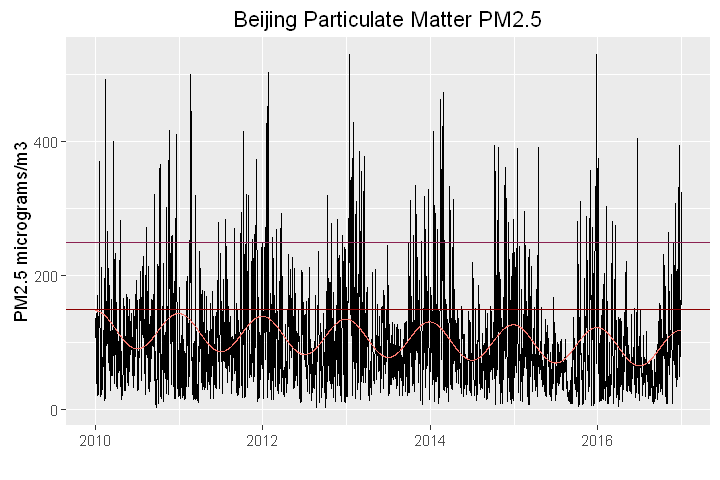

In [35]:
# PM2.5 plot with trend function and PM2.5 limits equivalent to 200 and 300 AQI
ggplot(dat, aes(x = Date)) + 
  geom_line(aes(y = Value_HL)) + 
  geom_line(aes(y = season, colour = 'season')) + xlab("") + ylab("PM2.5 micrograms/m3") +
  theme(legend.position="none") + ggtitle("Beijing Particulate Matter PM2.5") +
  geom_hline(yintercept = 150, colour = "red4") +
  geom_hline(yintercept = 250, colour = "violetred4")

In [39]:
# calculated daily changes in the concentration
dat$ConDiff <- c(0, diff(dat$Value_HL))

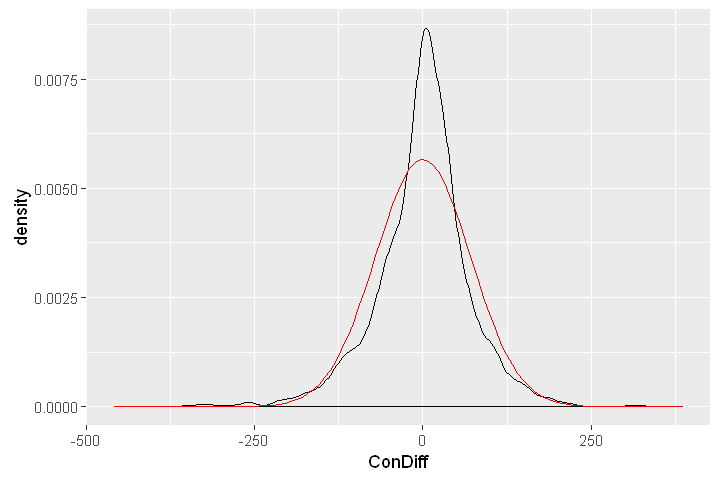

In [46]:
# plot daily changes vs normal
ggplot(dat, aes(x=ConDiff)) + geom_density() + 
stat_function(fun = dnorm, args = list(mean = mean(dat$ConDiff), sd = sd(dat$ConDiff)), colour = 'red')

Non-normal density for changes in concentration value, as expected. We have seen large jumps, and time varying volatility in
the plot above. Let us try to estimate the volatility with one diffusion coefficient per month, eg. 12 of them

In [47]:
# vector for storing monthly sigma estimates
sig <- vector()

# calculation
for (i in 1:12){
  sig[i] <- sqrt(sum(subset(dat, Month==i)$ConDiff**2)/length(subset(dat, Month==i)$ConDiff))
}

# report as data frame
sig <- as.data.frame(sig)
rownames(sig) <- c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
colnames(sig) <- 'Sigma'
sig

,Sigma
Jan,94.86993
Feb,92.49942
Mar,81.24856
Apr,59.10831
May,49.29055
Jun,54.42655
Jul,44.25515
Aug,38.60887
Sep,46.20081
Oct,81.46431


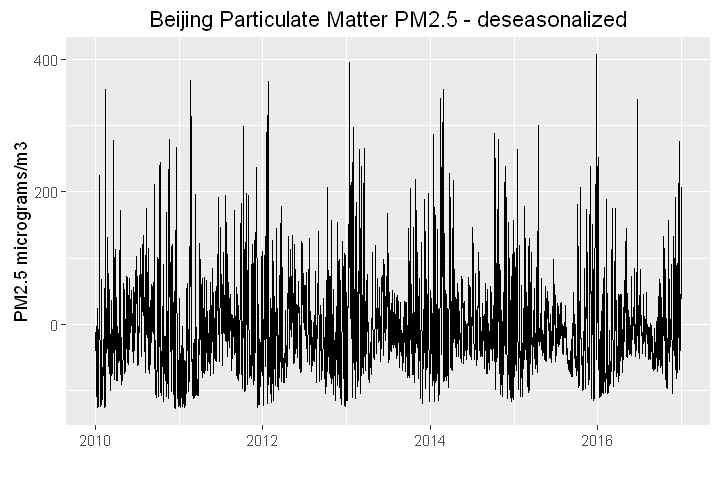

In [48]:
# plot detrended PM2.5 = PM2.5 - season
ggplot(dat, aes(x = Date)) + 
  geom_line(aes(y = ValSeas)) + 
  xlab("") + ylab("PM2.5 micrograms/m3") +
  theme(legend.position="none") + ggtitle("Beijing Particulate Matter PM2.5 - deseasonalized")

In [52]:
# fit sinusoidal trend function to AQI
aqi_season <- lm(dat$AQI ~ dat$d + sin( 2*pi*dat$d / 365 ) + cos( 2*pi*dat$d / 365 ))
dat$aqi_season <- predict(aqi_season, data.frame(dat$d))

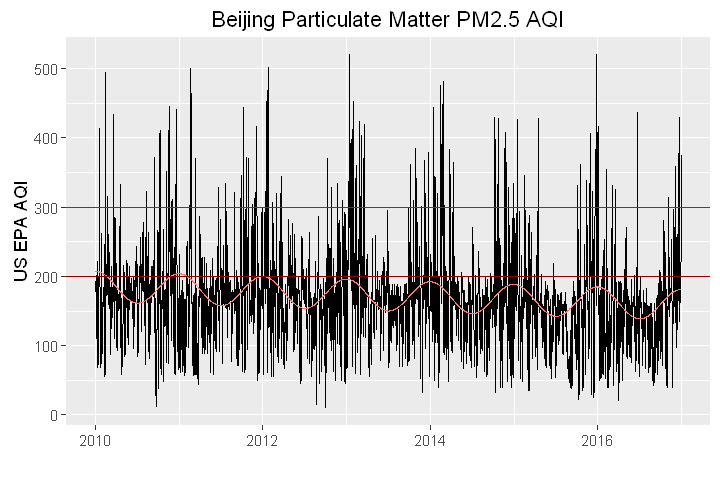

In [53]:
# AQI plot with trend function and 200 and 300 AQI limits
ggplot(dat, aes(x = Date)) + 
  geom_line(aes(y = AQI)) + 
  geom_line(aes(y = aqi_season, colour = 'aqi_season')) + 
  xlab("") + ylab("US EPA AQI") +
  theme(legend.position="none") + ggtitle("Beijing Particulate Matter PM2.5 AQI") +
  geom_hline(yintercept = 200, colour = "red4") +
  geom_hline(yintercept = 300, colour = "violetred4")

We will model the underlying processes for the PAS index, but first we will apply simple burn analysis to investigate
historical contract values for the limit $AQI = 300$ for monthly contracts in the period 2012-2015.

## Burn analysis

In [54]:
# calculate monthly pas scores with the sourced calc_pas function, store in burn table and reshape
burn <- setDT(dat)[, .(PAS = calc_pas(AQI)$PAS), by = .(Year, Month)]
burn <- reshape(burn, idvar = "Month", timevar = "Year", direction = "wide")
print(burn)

    Month PAS.2010 PAS.2011 PAS.2012 PAS.2013 PAS.2014 PAS.2015 PAS.2016
 1:     1      150        0      627     1097      265      133      208
 2:     2      211      546        7      271      909       77       54
 3:     3      241       70       84      298       98        0       57
 4:     4       33        0        0        0       64      128        0
 5:     5        0        0        0        0        0        0        0
 6:     6        0       29        0        0        0        0      137
 7:     7        0       34        0        0        0        0        0
 8:     8       22       21        0        0        0        0        0
 9:     9       71       58        0        0        0        0        0
10:    10      364      326       98      168      464       92        0
11:    11      434       16       34       43      295      216       14
12:    12      305      294       10      147       63      659      543


We see clearly that the extreme pollution is a seasonal problem during late fall/ winter. In the following, we will develop a 
stochastic model for the PM2.5 and the AQI. This will be the basis for pricing futures and options on futures.

## Modelling the PM2.5 concentration and the AQI

The PM2.5 and the AQI will be modeled with an Ornstein-Uhlenbeck process with a deterministic seasonal mean function, ref above

## Pricing PAS index futures

The time $t$ value of a long position in a futures contract settled at $T_2$:

\begin{equation}
e^{-r(T_2-t)}[PAS(T_1, T_2)-F_{PAS}(t, T_1, T_2)]
\end{equation}

## Pricing European options on PAS index futures